In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import unicodedata as uni
import time
import re
def normalize(string):
    return uni.normalize('NFKD',string).encode('ascii','ignore')
from sys import stdout
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF with IDF on categories.

In [31]:
TRAINING_SET_PATH = 'Data/cleantrain.csv'
TEST_SET_PATH = 'Data/cleantest.csv'
RAYON_SET_PATH = 'Data/rayon.csv'
SEPARATOR = ','
INDEX_COL = 'Identifiant_Produit'
PRICE_COL = 'prix'
CAT_COL1 = 'Categorie1'
CAT_COL2 = 'Categorie2'
CAT_COL3 = 'Categorie3'
DESC_COL = 'Description'
LIBE_COL = 'Libelle'
MARQ_COL = 'Marque'
PRICE_COL = 'prix'
CDIS_COL = 'Produit_Cdiscount'
MARQ_DESC = 'Marque_in_Description' 
MARQ_LIBE = 'Marque_in_Libelle'
INT_LIBE_DESC = 'Intersection_Libe_Desc'
LEN_LIBE = 'Longueur_Libelle'
LEN_DESC = 'Longueur_Description'
LEN_INT = 'Longueur Intersection'
LIBE_DESC = 'Percent_Libe_in_Desc'
PERCENT_CAPTURE_LIBE = 'Percent_capture_libe'
PERCENT_CAPTURE_DESC = 'Percent_capture_desc'
PERCENT_CAPTURE_INT = 'Percent_capture_int'

AUGMENTED_DESC_COL = 'Description+Libelle'

VOCABULARY_PATH_DESC = 'Data/vocabularyDesc.npy'
VOCABULARY_PATH_LIBE = 'Data/vocabularyLibe.npy'
VOCABULARY_PATH_INT = 'Data/vocabularyInt.npy'

PRED_PATH_LOG = 'Prediction/Pred_log_Cdiscount'
STOPLIST = set('un une le les la au aux de des ce se ma mon ton sa the of then it ou and tres sur on en in dans pour for with avec et ne pas tout all without sans du il votre son one je vous nos ses vos est tu es cet cette tout toute'.split())

In [ ]:
print "loading Data"
Ctrain = pd.read_csv(TRAINING_SET_PATH, sep=SEPARATOR,index_col=INDEX_COL)
Ctrain.fillna(' ',inplace=True)
Ctest = pd.read_csv(TEST_SET_PATH, sep=SEPARATOR,index_col=INDEX_COL)
Ctest.fillna(' ',inplace=True)
vocabularyDesc = np.load(VOCABULARY_PATH_DESC)
vocabularyLibe = np.load(VOCABULARY_PATH_LIBE)
vocabularyInt = np.load(VOCABULARY_PATH_INT)
vocDesc = set(vocabularyDesc)
vocLibe = set(vocabularyLibe)
vocInt = set(vocabularyInt)
#voc2 = voc.difference(STOPLIST)

Create a well distributed training set

In [6]:
def create_training_set(data_y,min_sample_by_cat,max_sample_by_cat):
    y = np.array(data_y)
    y_unique = data_y.unique()
    all_indices = np.arange(0,y.shape[0],1).astype(int)
    indices_by_cat = np.array([])
    y_indices = np.array([])
    progress = 0
    length = len(y_unique)
    for cat in y_unique:
        cat_indices = all_indices[y==cat]
        len_cat = len(cat_indices)
        if len_cat < min_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,min_sample_by_cat,replace=True)]
            y_indices =  np.r_[y_indices,[cat]*min_sample_by_cat]
        elif len_cat < max_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,len_cat,replace=True)]
            y_indices =  np.r_[y_indices,[cat]*len_cat]
        else:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,max_sample_by_cat,replace=True)]
            y_indices =  np.r_[y_indices,[cat]*max_sample_by_cat]
        progress +=1
        percent = progress * 100.0/ length
        count = int(np.floor(percent/2))
        stdout.write("\r\x1b[K" + "[" + count * "-" + (50-count)*" " + "] %.1f" %percent)
        stdout.flush()
    set_indices = np.array(indices_by_cat).flatten()
    return set_indices,y_indices

def create_training_set(data_y,min_sample_by_cat,max_sample_by_cat):
    y = np.array(data_y)
    y_unique = data_y.unique()
    all_indices = np.arange(0,y.shape[0],1).astype(int)
    indices_by_cat = np.array([])
    progress = 0
    length = len(y_unique)
    t = time.time()
    for cat in y_unique:
        cat_indices = all_indices[y==cat]
        len_cat = len(cat_indices)
        if len_cat < min_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,min_sample_by_cat,replace=True)]
        elif len_cat < max_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,len_cat,replace=True)]
        else:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,max_sample_by_cat,replace=True)]
        progress +=1
        percent = progress * 100.0/ length
        count = int(np.floor(percent/2))
        elapse_t = time.time() - t
        eta = elapse_t * (100.0 - percent) / percent / 60
        stdout.write("\r\x1b[K" + "[" + count * "-" + (50-count)*" " + "] %.1f p" %percent + "       eta :  %.1f min" %eta )
        stdout.flush()
    set_indices = np.array(indices_by_cat).flatten()
    return set_indices

def create_indicies_ref_by_cat(data_y):
    y = np.array(data_y)
    y_unique = data_y.unique()
    res = {}
    all_indices = np.arange(0,y.shape[0],1).astype(int)
    progress = 0
    length = len(y_unique)
    t = time.time()
    for cat in y_unique:
        cat_indices = all_indices[y==cat]
        res[cat] = cat_indices
        progress +=1
        percent = progress * 100.0/ length
        count = int(np.floor(percent/2))
        elapse_t = time.time() - t
        eta = elapse_t * (100.0 - percent) / percent / 60
        stdout.write("\r\x1b[K" + "[" + count * "-" + (50-count)*" " + "] %.1f p" %percent + "       eta :  %.1f min" %eta )
        stdout.flush()
    return res

def create_training_set_with_all_marque(data_y,data_marques,min_sample_by_cat,max_sample_by_cat,min_by_marque,cat_indices_dic):
    y = np.array(data_y)
    marques = np.array(data_marques)
    y_unique = data_y.unique()
    all_indices = np.arange(0,y.shape[0],1).astype(int)
    indices_by_cat = np.array([])
    progress = 0
    length = len(y_unique)
    t = time.time()
    for cat in y_unique:
        cat_indices = cat_indices_dic[cat]
        marques_cat = marques[cat_indices]
        marques_cat_unique = set(marques_cat)
        len_cat = len(cat_indices)
        if len_cat < min_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,min_sample_by_cat,replace=True)]
        elif len_cat < max_sample_by_cat:
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,len_cat,replace=True)]
        elif len(marques_cat_unique) < max_sample_by_cat:
            for marque in set(marques_cat):
                cat_marque_indices = cat_indices[marques_cat == marque]
                indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_marque_indices,min_by_marque,replace=True)]
            indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_indices,max_sample_by_cat-len(marques_cat_unique),replace=True)]
        else:
            for marque in set(marques_cat):
                cat_marque_indices = cat_indices[marques_cat == marque]
                indices_by_cat = np.r_[indices_by_cat,np.random.choice(cat_marque_indices,min_by_marque,replace=True)]
        progress +=1
        percent = progress * 100.0/ length
        count = int(np.floor(percent/2))
        elapse_t = time.time() - t
        eta = elapse_t * (100.0 - percent) / percent / 60
        stdout.write("\r\x1b[K" + "[" + count * "-" + (50-count)*" " + "] %.1f p" %percent + "       eta :  %.1f min" %eta )
        stdout.flush()
    set_indices = np.array(indices_by_cat).flatten()
    return set_indices

In [5]:
cat_indices_dic = create_indicies_ref_by_cat(Ctrain[CAT_COL3])
print " "
train_ind = create_training_set_with_all_marque(Ctrain[CAT_COL3],Ctrain['Marque'],40,100,2,cat_indices_dic)
print " "

[--------------------------------------------------] 100.0 p       eta :  0.0 min

In [8]:
print "train creation"
train_ind = create_training_set(Ctrain[CAT_COL3],60,200)
print " "
print "train size", train_ind.shape[0]
print "test creation"
test_ind = create_training_set(Ctrain[CAT_COL3],4,10)
print " "
print "test size", test_ind.shape[0]

train creation
[--------------------------------------------------] 100.0 p       eta :  0.0 min 
train size 774650
test creation
[--------------------------------------------------] 100.0 p       eta :  0.0 min 
test size 53978


##Create a model to find probabilities of categories 1

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 1"
Tfidf1Desc = TfidfVectorizer(vocabulary=vocDesc)
CategorieDOC = Ctrain.ix[:,[CAT_COL1,DESC_COL]].groupby(CAT_COL1)[DESC_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[DESC_COL]
cat1Desc_vector = Tfidf1Desc.fit_transform(Libelle)
del CategorieDOC
del Libelle

from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 1"
Tfidf1Libe = TfidfVectorizer(vocabulary=vocLibe)
CategorieDOC = Ctrain.ix[:,[CAT_COL1,LIBE_COL]].groupby(CAT_COL1)[LIBE_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[LIBE_COL]
cat1Libe_vector = Tfidf1Libe.fit_transform(Libelle)
del CategorieDOC
del Libelle

from sklearn.feature_extraction.text import CountVectorizer
print "creating Count for categorie 1"
Count1Int = CountVectorizer(vocabulary=vocInt)

from sklearn.feature_extraction.text import CountVectorizer
print "creating Count for categorie 1"
Count1Marq = CountVectorizer(binary=True)
Count1Marq.fit(Ctrain[MARQ_COL])


creating Tfidf for categorie 1
creating Tfidf for categorie 1
creating Count for categorie 1
creating Count for categorie 1


CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
from sklearn import preprocessing
y_cat1_number = preprocessing.LabelEncoder()
y_cat1_table = preprocessing.LabelBinarizer()
y_cat1_number.fit(Ctrain[CAT_COL1].unique())
y_cat1_table.fit(y_cat1_number.classes_)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [17]:
y_train1 = y_cat1_number.transform(Ctrain.ix[train_ind,CAT_COL1])
trainVector1Desc = Tfidf1Desc.transform(Ctrain.ix[train_ind,DESC_COL])
trainVector1Libe = Tfidf1Libe.transform(Ctrain.ix[train_ind,LIBE_COL])
trainVector1Int = Count1Int.transform(Ctrain.ix[train_ind,INT_LIBE_DESC])
trainVector1Marq = Count1Marq.transform(Ctrain.ix[train_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[train_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[train_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
#cat1_vector_val = trainVector1.dot(cat1_vector.T)
trainVector1 = scipy.sparse.hstack([trainVector1Desc,trainVector1Libe,trainVector1Int,trainVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
trainVector1

<774650x252344 sparse matrix of type '<type 'numpy.float64'>'
	with 17933648 stored elements in COOrdinate format>

In [18]:
y_test1 = y_cat1_number.transform(Ctrain.ix[test_ind,CAT_COL1])
testVector1Desc = Tfidf1Desc.transform(Ctrain.ix[test_ind,DESC_COL])
testVector1Libe = Tfidf1Libe.transform(Ctrain.ix[test_ind,LIBE_COL])
testVector1Int = Count1Int.transform(Ctrain.ix[test_ind,INT_LIBE_DESC])
testVector1Marq = Count1Marq.transform(Ctrain.ix[test_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[test_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[test_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
#cat1_vector_val = trainVector1.dot(cat1_vector.T)
testVector1 = scipy.sparse.hstack([testVector1Desc,testVector1Libe,testVector1Int,testVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
testVector1

<53978x252344 sparse matrix of type '<type 'numpy.float64'>'
	with 1271448 stored elements in COOrdinate format>

In [19]:
from sklearn.linear_model import LogisticRegression
mod1 = LogisticRegression(verbose=5,max_iter=100)
mod1.fit(trainVector1,y_train1)
val = int(np.floor(mod1.score(testVector1,y_test1)*100))
print val
predict1 = mod1.predict_proba(testVector1)

[LibLinear]93


In [17]:
from sklearn.ensemble import RandomForestClassifier
mod = RandomForestClassifier(n_jobs=16, n_estimators=60)
mod.fit(trainVector1,y_train1)
val = int(np.floor(mod.score(testVector1,y_test1)*100))
print val

88


In [21]:
print mod1.score(trainVector1,y_train1)*100
y_pred = mod1.predict(testVector1)

95.6551991222


[[ 141    0    0 ...,    0    0    0]
 [   0  174    0 ...,    0    0    0]
 [   0    0  329 ...,    1    0    0]
 ..., 
 [   0    0    0 ..., 1517    0    1]
 [   0    0    0 ...,    0  150    0]
 [   0    0    0 ...,    0    0  989]]


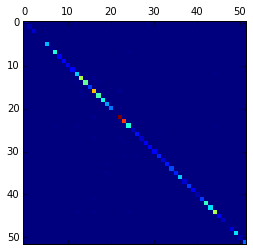

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1, y_pred)
print(cm)
plt.matshow(cm)

##Create a model for categorie 2

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 2"
Tfidf2Desc = TfidfVectorizer(vocabulary=vocDesc)
CategorieDOC = Ctrain.ix[:,[CAT_COL2,DESC_COL]].groupby(CAT_COL2)[DESC_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[DESC_COL]
cat2Desc_vector = Tfidf2Desc.fit_transform(Libelle)
del CategorieDOC
del Libelle

from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 2"
Tfidf2Libe = TfidfVectorizer(vocabulary=vocLibe)
CategorieDOC = Ctrain.ix[:,[CAT_COL2,LIBE_COL]].groupby(CAT_COL2)[LIBE_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[LIBE_COL]
cat2Libe_vector = Tfidf2Libe.fit_transform(Libelle)
del CategorieDOC
del Libelle

creating Tfidf for categorie 2
creating Tfidf for categorie 2


In [25]:
from sklearn import preprocessing
y_cat2_number = preprocessing.LabelEncoder()
y_cat2_table = preprocessing.LabelBinarizer()
y_cat2_number.fit(Ctrain[CAT_COL2].unique())
y_cat2_table.fit(y_cat2_number.classes_)
print len(y_cat2_number.classes_)

536


In [26]:
y_train2 = y_cat2_number.transform(Ctrain.ix[train_ind,CAT_COL2])
trainVector2Desc = Tfidf2Desc.transform(Ctrain.ix[train_ind,DESC_COL])
trainVector2Libe = Tfidf2Libe.transform(Ctrain.ix[train_ind,LIBE_COL])
trainVector1Int = Count1Int.transform(Ctrain.ix[train_ind,INT_LIBE_DESC])
trainVector1Marq = Count1Marq.transform(Ctrain.ix[train_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[train_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[train_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
cat1_pred = y_cat1_table.transform(y_train1)
trainVector2 = scipy.sparse.hstack([trainVector2Desc,trainVector2Libe,trainVector1Int,trainVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
trainVector2 = scipy.sparse.hstack([trainVector2,cat1_pred])
trainVector2

<774650x252396 sparse matrix of type '<type 'numpy.float64'>'
	with 17933648 stored elements in COOrdinate format>

In [27]:
y_test2 = y_cat2_number.transform(Ctrain.ix[test_ind,CAT_COL2])
testVector2Desc = Tfidf2Desc.transform(Ctrain.ix[test_ind,DESC_COL])
testVector2Libe = Tfidf2Libe.transform(Ctrain.ix[test_ind,LIBE_COL])
testVector1Int = Count1Int.transform(Ctrain.ix[test_ind,INT_LIBE_DESC])
testVector1Marq = Count1Marq.transform(Ctrain.ix[test_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[test_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[test_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
cat1_pred = mod1.predict_proba(testVector1)
testVector2 = scipy.sparse.hstack([testVector2Desc,testVector2Libe,testVector1Int,testVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
testVector2 = scipy.sparse.hstack([testVector2,cat1_pred])
testVector2

<53978x252396 sparse matrix of type '<type 'numpy.float64'>'
	with 4078304 stored elements in COOrdinate format>

In [ ]:
from sklearn.linear_model import LogisticRegression
mod2 = LogisticRegression(verbose=5,max_iter=100)
mod2.fit(trainVector2,y_train2)
val = int(np.floor(mod2.score(testVector2,y_test2)*100))
print val
predict2 = mod2.predict_proba(testVector2)

In [32]:
rayon = pd.read_csv(RAYON_SET_PATH,sep=';')

In [33]:
ray = rayon[['Categorie1','Categorie2']].drop_duplicates()

In [34]:
def find_parent_cat(cat2):
    return ray[ray['Categorie2'] == cat2]['Categorie1']

In [35]:
def recalculate_proba(pred_proba2,pred_proba1):
    proba = np.zeros(pred_proba2.shape)
    for i in range(pred_proba2.shape[1]):
        j = y_cat1_number.transform(find_parent_cat(y_cat2_number.inverse_transform(i)))[0]
        proba[:,i] = pred_proba2[:,i] * pred_proba1[:,j]
    return proba

In [36]:
y_cat2_number.inverse_transform(0)
predictn = recalculate_proba(predict2,predict1)

In [37]:
predn = np.argmax(predictn,axis=1)

In [38]:
res = 0
for i in range(len(y_test2)):
    if predn[i] == y_test2[i]:
        res +=1
print res * 1.0 / len(y_test2)

0.891826299604


categorie3

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 3"
Tfidf3Desc = TfidfVectorizer(vocabulary=vocDesc)
CategorieDOC = Ctrain.ix[:,[CAT_COL3,DESC_COL]].groupby(CAT_COL3)[DESC_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[DESC_COL]
cat3Desc_vector = Tfidf3Desc.fit_transform(Libelle)
del CategorieDOC
del Libelle

from sklearn.feature_extraction.text import TfidfVectorizer
print "creating Tfidf for categorie 3"
Tfidf3Libe = TfidfVectorizer(vocabulary=vocLibe)
CategorieDOC = Ctrain.ix[:,[CAT_COL3,LIBE_COL]].groupby(CAT_COL3)[LIBE_COL].apply(lambda x: "%s" % ' '.join(x))
Libelle = CategorieDOC.reset_index()[LIBE_COL]
cat3Libe_vector = Tfidf3Libe.fit_transform(Libelle)
del CategorieDOC
del Libelle

creating Tfidf for categorie 3
creating Tfidf for categorie 3


In [40]:
from sklearn import preprocessing
y_cat3_number = preprocessing.LabelEncoder()
y_cat3_table = preprocessing.LabelBinarizer()
y_cat3_number.fit(Ctrain[CAT_COL3].unique())
y_cat3_table.fit(y_cat3_number.classes_)
print len(y_cat3_number.classes_)

5789


In [42]:
y_train3 = y_cat3_number.transform(Ctrain.ix[train_ind,CAT_COL3])
trainVector3Desc = Tfidf3Desc.transform(Ctrain.ix[train_ind,DESC_COL])
trainVector3Libe = Tfidf3Libe.transform(Ctrain.ix[train_ind,LIBE_COL])
trainVector1Int = Count1Int.transform(Ctrain.ix[train_ind,INT_LIBE_DESC])
trainVector1Marq = Count1Marq.transform(Ctrain.ix[train_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[train_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[train_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
cat1_pred = y_cat1_table.transform(y_train1)
cat2_pred = y_cat2_table.transform(y_train2)
trainVector3 = scipy.sparse.hstack([trainVector3Desc,trainVector3Libe,trainVector1Int,trainVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
trainVector3 = scipy.sparse.hstack([trainVector3,cat1_pred,cat2_pred])
trainVector3

<774650x252932 sparse matrix of type '<type 'numpy.float64'>'
	with 17936537 stored elements in COOrdinate format>

In [43]:
y_test3 = y_cat3_number.transform(Ctrain.ix[test_ind,CAT_COL3])
testVector3Desc = Tfidf3Desc.transform(Ctrain.ix[test_ind,DESC_COL])
testVector3Libe = Tfidf3Libe.transform(Ctrain.ix[test_ind,LIBE_COL])
testVector1Int = Count1Int.transform(Ctrain.ix[test_ind,INT_LIBE_DESC])
testVector1Marq = Count1Marq.transform(Ctrain.ix[test_ind,MARQ_COL])
price_mat = np.array(Ctrain.ix[test_ind,PRICE_COL].apply(lambda x: np.log10(x+2)))
features_mat = Ctrain.ix[test_ind,[LEN_LIBE,LEN_DESC,LEN_INT,LIBE_DESC,MARQ_DESC,MARQ_LIBE]]
cat1_pred = mod1.predict_proba(testVector1)
cat2_pred = mod2.predict_proba(testVector2)
testVector3 = scipy.sparse.hstack([testVector3Desc,testVector3Libe,testVector1Int,testVector1Marq,price_mat.reshape((price_mat.shape[0],1)),features_mat])
testVector3 = scipy.sparse.hstack([testVector3,cat1_pred,cat2_pred])
testVector3

<53978x252932 sparse matrix of type '<type 'numpy.float64'>'
	with 33010512 stored elements in COOrdinate format>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
mod3 = RandomForestClassifier(n_jobs=8, n_estimators=50)
mod3.fit(trainVector3,y_train3)
val = int(np.floor(mod3.score(testVector3,y_test3)*100))
print val

In [ ]:
from sklearn.linear_model import LogisticRegression
mod3 = LogisticRegression(verbose=5,max_iter=100)
mod3.fit(trainVector3,y_train3)
val = int(np.floor(mod3.score(testVector3,y_test3)*100))
print val

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
mod4 = OneVsRestClassifier(LinearSVC(),n_jobs=4)
mod4.fit(trainVector3,y_train3)
val = int(np.floor(mod4.score(testVector3,y_test3)*100))
print val

In [14]:
vectorsTest = Tfidf3.transform(Ctest[AUGMENTED_DESC_COL])
price_mat = np.array(Ctest[PRICE_COL].apply(lambda x: np.log10(x+2)))
vectorsTest = scipy.sparse.hstack([vectorsTest,price_mat.reshape((price_mat.shape[0],1))])

In [15]:
prediction = Ctest.copy()
prediction['Id_Categorie'] = y_cat3_number.inverse_transform(mod4.predict(vectorsTest))
prediction.index.name = 'Id_Produit'
prediction.drop([PRICE_COL,AUGMENTED_DESC_COL,PERCENT_CAPTURE,'Marque'],inplace=True,axis=1)
prediction.to_csv(PRED_PATH_LOG + "_" + str(val) + "_p" + ".csv",sep=";")

In [16]:
mod4.score(testVector3,y_test3)

0.85479269331950058